### Hello. This notebook will be exploring some preliminary data sets.###
**In case you're wondering, my project is going to be tracking (and predicting) breakthrough technologies by modeling technology mentions in Academic Journals, Popular Media, and Job Postings . Enjoy!**

In [28]:
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

**In this preliminary exploration I will only be looking at mentions of "Machine Learning" or "ML"**

In [2]:
# The first prelim dataset is from naukri: 
jobs= pd.read_csv('./data/NaukriJobs_kaggle/naukri_com-job_sample.csv')

jobs.info()
# I am interested in the Launch Date, the Course Title, 

#Have to look at the range of dates, for sampling purposes
jobs['postdate'].sort_values()

## Naukri Date Ranges: 1/2015 - 1/2017

In [5]:
# Curtesy of 
#https://stackoverflow.com/questions/842856/whats-the-most-efficient-way-to-find-one-of-several-substrings-in-python

def wordlist_to_regex(words):
    escaped = map(re.escape, words)
    combined= '|'.join(sorted(escaped, key=len, reverse=True))
    return re.compile(combined)

In [7]:
mlwords=[' machine learning ', 
         ' artificial intelligence ']
myregs= wordlist_to_regex(mlwords)

In [8]:
wordmatch_mask=[myregs.search(s.lower()) != None for s in jobs['jobdescription'] if isinstance(s, str)]

In [ ]:
jobs.columns

In [9]:
# If I decide to update the schema, might include some of ^^ these as well
mljobs=jobs.loc[wordmatch_mask,['postdate', 'jobdescription', 'jobtitle', 'skills', 'uniq_id']]

In [10]:
#now lets turn the date to a datetime
mljobs['postdate']= mljobs['postdate'].astype('datetime64')

In [ ]:
# mljobs.groupby(mljobs['postdate'].dt.day).count().plot(kind="bar")
counts= pd.DataFrame(mljobs['postdate'].value_counts(sort=False))

In [ ]:
#Some visualization on what we're looking at
plt.figure(figsize=(16, 8))
plt.scatter(counts.index, counts)
plt.show()

## The Schema I want: ##

**Date, id, source**

In [23]:
#pull the relavent columns into a csv called naukri.csv
csv_df= mljobs[['postdate', 'uniq_id']]
# csv_df.loc[:,'source']='naukri'
csv_df=csv_df.assign(source='naukri')

csv_df.to_csv('./cleaned_data/naukri.csv')

In [24]:
csv_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 42 to 21989
Data columns (total 3 columns):
postdate    174 non-null datetime64[ns]
uniq_id     174 non-null object
source      174 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 4.1+ KB


## Ok that was the first dataset. Let's try loading some more...##

**The PushShift API provides a nice aggregator for Reddit, so it makes my job easy for that site!**


In [1]:
import requests, json

def pushshift_to_the_limit(search_term):
    
    '''Requires pandas, requests and json library. Aggregates mentions of search term on Reddit thru comments and submissions'''
    
    comment_url= "https://api.pushshift.io/reddit/search/comment/"
    subm_url= "https://api.pushshift.io/reddit/search/submission/"
    
    comm_json= requests.get(f"{comment_url}?q={search_term}&aggs=created_utc&frequency=day&size=0")
    subm_json= requests.get(f"{subm_url}?q={search_term}&aggs=created_utc&frequency=day&size=0")
    comm_data=json.loads(comm_json.content)['aggs']['created_utc']
    subm_data=json.loads(subm_json.content)['aggs']['created_utc'] ##Now the data are in array format
    
    # Organize the responses into dicts, to load to pandas
    
    comm_dict={
        "day":[ x['key'] for x in comm_data],
        f"comments":[x['doc_count'] for x in comm_data],
    }
    subm_dict={
        "day":[ x['key'] for x in subm_data],
        f"submissions":[x['doc_count'] for x in subm_data],
    }
    
    comm_df= pd.DataFrame(comm_dict)
    comm_df.day=pd.to_datetime(comm_df.day, unit='s') 
    
    subm_df= pd.DataFrame(subm_dict)
    subm_df.day=pd.to_datetime(subm_df.day, unit='s') 
    
    tot_df=comm_df.merge(subm_df, on='day', how='outer').fillna(0)
    
    tot_df['total']=tot_df['comments']+tot_df['submissions']
    
    return tot_df

In [2]:
ml_df=pushshift_to_the_limit('machine learning')
ml_df.plot('day', 'total')

NameError: name 'pd' is not defined

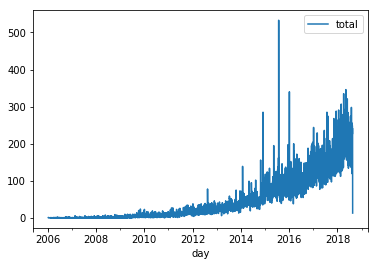

In [29]:
ai_df=pushshift_to_the_limit('artificial intelligence')
ai_df.plot('day', 'total')

In [31]:
ai_df.to_csv('./cleaned_data/reddit_AI.csv')
ml_df.to_csv('./cleaned_data/reddit_ML.csv')

## Interesting to compare and contrast the two... ##

**OK so we've looked (preliminarily) at Job postings and social mentions. How about academic literature?**

In [ ]:
#We'll query Google Scholar via the scholarly package
# import scholarly

### Scratch that. [Scholarly](https://pypi.org/project/scholarly/0.2/) is a nice api, but it doesn't provide a key field, date, easily ###
**You have to .fill() the generator it returns, which takes a long time, is expensive, and causes 403 forbidden errors quite a bit. _Note to future self: modify the source code to return date with the first call_**

In [89]:
#instead let's focus on a nice easy-to-use api: arXiv
import urllib
import time
import feedparser

base_url = 'http://export.arxiv.org/api/query?'

response= urllib.request.urlopen(base_url+
                                 f'search_query=ti:%22machine+learning%22+OR+%22artificial+intelligence%22'+
                                 '&start=0&max_results=15').read()


In [117]:
feed= feedparser.parse(response)

In [141]:
int(feed.feed.opensearch_totalresults)

18601

In [94]:
search_query='all:machine learning'
start=0
total_results= 200
results_per_iteration= 20
wait_time = 3

for i in range(start, total_results, results_per_iteration):
    print(f"Results {i}-{i + results_per_iteration}")
    
    query= f'search_query={search_query}&start={i}&max_results={results_per_iteration}'
    
    response= urllib.request.urlopen(base_url+query).read()
    
    feed= feedparser.parse(response)
    
    for entry in feed.entries:
        print(f"arxiv-id: {entry.id.split('/abs/')[-1]}")
        print(f"Title: {entry.title}")
        print(f"Author: {entry.author}")
        
    print('sleeping for 3 secs')
    time.sleep(wait_time)

Results 0-20
arxiv-id: 1611.00467v1
Title: A Performance Survey on Stack-based and Register-based Virtual Machines
Author: Siqi Liu
sleeping for 3 secs
arxiv-id: 0910.1761v1
Title: Decomposition of forging dies for machining planning
Author: Bernard Anselmetti
sleeping for 3 secs
arxiv-id: quant-ph/0508083v1
Title: Deletion of imperfect cloned copies
Author: Binayak. S. Choudhury
sleeping for 3 secs
arxiv-id: 1007.3303v1
Title: A New Approach to Abstract Machines - Introduction to the Theory of
  Configuration Machines
Author: Zhaohua Luo
sleeping for 3 secs
arxiv-id: 1212.2686v1
Title: Joint Training of Deep Boltzmann Machines
Author: Yoshua Bengio
sleeping for 3 secs
arxiv-id: 1804.06022v1
Title: Predicting Future Machine Failure from Machine State Using Logistic
  Regression
Author: Parth Nabar
sleeping for 3 secs
arxiv-id: quant-ph/0501176v2
Title: Simulations of Quantum Turing Machines by Quantum Multi-Stack Machines
Author: Daowen Qiu
sleeping for 3 secs
arxiv-id: 1304.0053v2
Tit

Results 120-140
arxiv-id: 1611.00467v1
Title: A Performance Survey on Stack-based and Register-based Virtual Machines
Author: Siqi Liu
sleeping for 3 secs
arxiv-id: 0910.1761v1
Title: Decomposition of forging dies for machining planning
Author: Bernard Anselmetti
sleeping for 3 secs
arxiv-id: quant-ph/0508083v1
Title: Deletion of imperfect cloned copies
Author: Binayak. S. Choudhury
sleeping for 3 secs
arxiv-id: 1007.3303v1
Title: A New Approach to Abstract Machines - Introduction to the Theory of
  Configuration Machines
Author: Zhaohua Luo
sleeping for 3 secs
arxiv-id: 1212.2686v1
Title: Joint Training of Deep Boltzmann Machines
Author: Yoshua Bengio
sleeping for 3 secs
arxiv-id: 1804.06022v1
Title: Predicting Future Machine Failure from Machine State Using Logistic
  Regression
Author: Parth Nabar
sleeping for 3 secs
arxiv-id: quant-ph/0501176v2
Title: Simulations of Quantum Turing Machines by Quantum Multi-Stack Machines
Author: Daowen Qiu
sleeping for 3 secs
arxiv-id: 1304.0053v2


In [222]:
def arx_and_recreation(search_term, start_idx, scope='ti'):
    '''uses urllib, time, and feedparser'''
    #first escape search terms
    search_term= search_term.replace('"',"%22").replace(" ", "+");
    # set wait time and iteration step
    iterstep= 200;
#     wait_time= .25 #make this 3 to 'play nice' with the api. I am nice I promise! but impatient atm
    base_url = 'http://export.arxiv.org/api/query?'
    start= start_idx
    date_dict={
        "date":[],
        "article_id": [],
        "source": "arXiv"
    }
    while True:
        response= urllib.request.urlopen(base_url+f"search_query={scope}:{search_term}&sortBy=submittedDate&sortOrder=ascending&start={start}&max_results={iterstep}")
        feed= feedparser.parse(response)
        if not feed.entries:
            print('query complete')
            print(f"There should be {feed.feed.opensearch_totalresults} results?")
            break
        date_dict['date'].extend([entry.published for entry in feed.entries])
        date_dict['article_id'].extend([entry.id.split('/abs/')[-1] for entry in feed.entries])
        print(f"gathering results {start} to {start + iterstep-1} ")
        start = start + iterstep
#         time.sleep(wait_time)
        
    return pd.DataFrame(date_dict)
        
    

### You can't see it but I did a very manual collection of articles (for some reason the api wasn't playing nice >_>) ###

In [235]:
arx_df11= arx_and_recreation('"machine learning" OR "artificial intelligence"', 18200)

arx_df11.head()

arx_df11.to_csv('./cleaned_data/arXiv_ml_and_ai11.csv')

gathering results 18200 to 18399 
gathering results 18400 to 18599 
gathering results 18600 to 18799 
query complete
There should be 18601 results?


In [238]:
arx_df11.date=pd.to_datetime(arx_df11.date)#groupby(arx_df11.date.dt.date)

In [241]:
counts=arx_df11.groupby(arx_df11.date.dt.date).count()

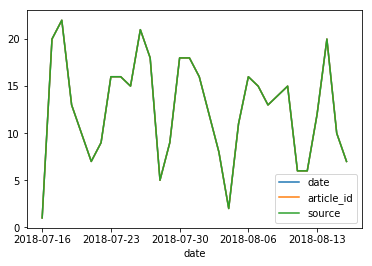

In [242]:
counts.plot()

In [14]:
import glob

glob.glob('./cleaned_data/shell_test/*.csv')

def concatenate(indir= './cleaned_data/arXiv*.csv', outfile='./cleaned_data/combined_arX.csv'):
    df_list=[]
    for file in glob.glob(indir):
        print(file)
        df= pd.read_csv(file)
        df_list.append(df)
    concatDf= pd.concat(df_list, axis=0);
    concatDf.to_csv(outfile)
    

# concatenate()

In [15]:
arx_df= pd.read_csv('./cleaned_data/combined_arX.csv')

In [18]:
arx_df=arx_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [20]:
arx_df.date= pd.to_datetime(arx_df.date)

In [25]:
counts=arx_df.groupby(arx_df.date.dt.year).count()

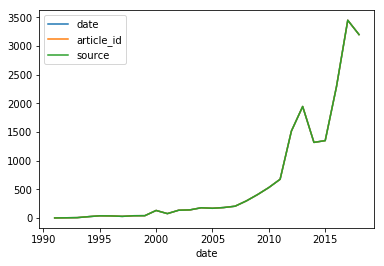

In [29]:
counts.plot()